In [1]:
# import gzip
# import json
# from collections import defaultdict
# from tqdm.notebook import tqdm

# # --- Configuration ---
# DATA_PATH = '/data/sukhanna/cse258/'
# FILE_FILTERED = "filtered_Kindle_Store.jsonl.gz"
# OUTPUT_SEQUENCES = "user_sequences.jsonl.gz"

# def build_and_save_sequences():
#     print(f"Reading filtered data from: {FILE_FILTERED}")
    
#     # 1. In-Memory Aggregation
#     # Structure: {user_id: [ {asin, ts, rating}, ... ]}
#     user_map = defaultdict(list)
    
#     try:
#         with gzip.open(DATA_PATH + FILE_FILTERED, 'rb') as f:
#             for line in tqdm(f, desc="Grouping Users"):
#                 try:
#                     data = json.loads(line.decode('utf-8').strip())
                    
#                     uid = data.get('user_id')
#                     asin = data.get('parent_asin')
                    
#                     # Timestamp Handling (Ensure Seconds)
#                     ts = data.get('unixReviewTime') or data.get('timestamp')
#                     if ts:
#                         ts = float(ts)
#                         if ts > 100000000000: # Fix ms to seconds
#                             ts = ts / 1000.0
                            
#                     # Optional: Keep rating for EDA
#                     rating = data.get('rating') or data.get('overall')
                    
#                     if uid and asin and ts:
#                         user_map[uid].append({
#                             'asin': asin,
#                             'ts': ts,
#                             'rating': float(rating) if rating else None
#                         })
                        
#                 except (json.JSONDecodeError, ValueError):
#                     continue
                    
#     except FileNotFoundError:
#         print(f"Error: {FILE_FILTERED} not found.")
#         return

#     print(f"Aggregation complete. Found {len(user_map):,} unique users.")
#     print(f"Sorting sequences and saving to {OUTPUT_SEQUENCES}...")

#     # 2. Sort and Save
#     saved_count = 0
    
#     with gzip.open(DATA_PATH + OUTPUT_SEQUENCES, 'wb') as f_out:
#         for uid, seq in tqdm(user_map.items(), desc="Writing Sequences"):
#             # SKIP users with insufficient history (e.g., < 5 items)
#             # This is a crucial final cleaning step for sequence models
#             # if len(seq) < 5:
#             #     continue
                
#             # SORT by Timestamp (Ascending)
#             seq.sort(key=lambda x: x['ts'])
            
#             # Create object
#             user_obj = {
#                 "user_id": uid,
#                 "sequence": seq
#             }
            
#             # Write line
#             f_out.write(json.dumps(user_obj).encode('utf-8') + b'\n')
#             saved_count += 1

#     print(f"\nSuccessfully saved {saved_count:,} sequences.")
#     # print(f"Dropped {len(user_map) - saved_count:,} users with < 5 interactions.")

# # --- Run ---
# build_and_save_sequences()

In [2]:
# import gzip
# import json
# from tqdm.notebook import tqdm

# # --- Configuration ---
# INPUT_SEQUENCES = "user_sequences.jsonl.gz"
# OUTPUT_FILTERED_SEQ = "filtered_user_sequences.jsonl.gz"
# MIN_SEQ_LEN = 5

# def apply_k_core_filter():
#     print(f"Applying K-Core Filter (K={MIN_SEQ_LEN})...")
#     print(f"Input: {INPUT_SEQUENCES}")
    
#     stats = {
#         "total_users": 0,
#         "kept_users": 0,
#         "dropped_users": 0,
#         "total_interactions": 0
#     }
    
#     try:
#         with gzip.open(DATA_PATH + INPUT_SEQUENCES, 'rb') as f_in, gzip.open(DATA_PATH + OUTPUT_FILTERED_SEQ, 'wb') as f_out:
#             for line in tqdm(f_in, desc="Filtering Users"):
#                 try:
#                     stats["total_users"] += 1
                    
#                     # Parse
#                     user_obj = json.loads(line.decode('utf-8').strip())
#                     seq = user_obj.get('sequence', [])
                    
#                     # Check Length
#                     if len(seq) >= MIN_SEQ_LEN:
#                         # Write to new file
#                         f_out.write(line)
#                         stats["kept_users"] += 1
#                         stats["total_interactions"] += len(seq)
#                     else:
#                         stats["dropped_users"] += 1
                        
#                 except (json.JSONDecodeError, ValueError):
#                     continue
                    
#     except FileNotFoundError:
#         print(f"Error: {INPUT_SEQUENCES} not found.")
#         return

#     # --- Final Report ---
#     print("\n" + "="*30)
#     print("FILTERING COMPLETE")
#     print("="*30)
#     print(f"Total Users Scanned:    {stats['total_users']:,}")
#     print(f"Users Kept (>= {MIN_SEQ_LEN}):      {stats['kept_users']:,} ({(stats['kept_users']/stats['total_users']):.1%})")
#     print(f"Users Dropped (< {MIN_SEQ_LEN}):     {stats['dropped_users']:,}")
#     print(f"Total Training Interactions: {stats['total_interactions']:,}")
#     print(f"\nSaved to: {OUTPUT_FILTERED_SEQ}")

# # --- Run ---
# apply_k_core_filter()

In [5]:
import gzip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Global Presentation Settings ---
def set_presentation_style():
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- 1. Load Metadata Lookup ---
def load_metadata_lookup(file_path):
    print("Step 1: Loading Metadata Lookup...")
    lookup = {}
    try:
        with gzip.open(file_path, 'rb') as f:
            for line in tqdm(f, desc="Indexing Metadata", unit=" items"):
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    asin = data.get('parent_asin')
                    if not asin: continue
                    
                    # 1. Price
                    price = 0.0
                    p_obj = data.get('price')
                    if isinstance(p_obj, (float, int)): price = float(p_obj)
                    elif isinstance(p_obj, str):
                        try: price = float(p_obj.replace('$','').replace(',',''))
                        except: pass
                    
                    # 2. Author
                    author = "UNK"
                    a_obj = data.get('author')
                    if isinstance(a_obj, dict): author = a_obj.get('name', 'UNK')
                    elif isinstance(a_obj, str): author = a_obj
                    
                    # 3. Category
                    category = "UNK"
                    cats = data.get('categories', [])
                    if isinstance(cats, list) and len(cats) > 0:
                        if len(cats) >= 3: category = cats[2]
                        else: category = cats[-1]
                        
                    lookup[asin] = {'p': price, 'a': author, 'c': category}
                except: continue
    except FileNotFoundError:
        print("Metadata file not found.")
    return lookup

# --- 2. Process Sequences ---
def process_sequences(seq_file_path, meta_lookup):
    """
    Streams sequence file and computes metrics.
    """
    stats = {
        "lengths": [],
        "avg_ratings": [],
        "avg_prices": [],
        "avg_iat_days": [],
        "author_diversity": [],
        "cat_diversity": []
    }
    
    print("\nStep 2: Processing Sequences...")
    total_users = 0
    
    try:
        with gzip.open(seq_file_path, 'rb') as f:
            for line in tqdm(f, desc="Processing Users", unit=" users"):
                try:
                    user_obj = json.loads(line.decode('utf-8').strip())
                    seq = user_obj.get('sequence', [])
                    
                    if not seq: continue
                    total_users += 1
                    
                    # A. Length
                    n = len(seq)
                    stats["lengths"].append(n)
                    
                    # B. Rating
                    ratings = [item.get('rating', 0) for item in seq]
                    stats["avg_ratings"].append(np.mean(ratings))
                    
                    # C. Metadata Metrics
                    prices = []
                    authors = set()
                    cats = set()
                    
                    for item in seq:
                        asin = item.get('asin')
                        meta = meta_lookup.get(asin)
                        if meta:
                            prices.append(meta['p'])
                            authors.add(meta['a'])
                            cats.add(meta['c'])
                    
                    if prices: stats["avg_prices"].append(np.mean(prices))
                    
                    # Diversity
                    stats["author_diversity"].append(len(authors) / n)
                    stats["cat_diversity"].append(len(cats) / n)
                    
                    # D. IAT
                    if n > 1:
                        timestamps = [item.get('ts', 0) for item in seq]
                        diffs = np.diff(timestamps) 
                        avg_gap_sec = np.mean(diffs)
                        stats["avg_iat_days"].append(avg_gap_sec / 86400.0)
                        
                except (json.JSONDecodeError, ValueError):
                    continue
    except FileNotFoundError:
        print(f"Error: {seq_file_path} not found.")
        return None
        
    print(f"Done. Analyzed {total_users:,} sequences.")
    return stats

# --- Execution ---
DATA_PATH = '/data/sukhanna/cse258/'
FILE_FILTERED = "filtered_Kindle_Store.jsonl.gz"
FILE_METADATA = "meta_Kindle_Store.jsonl.gz"
FILE_SEQEUNCES = "filtered_user_sequences.jsonl.gz"
lookup = load_metadata_lookup(DATA_PATH + FILE_METADATA)
seq_results = process_sequences(DATA_PATH + FILE_SEQEUNCES, lookup)

Step 1: Loading Metadata Lookup...


Indexing Metadata: 0 items [00:00, ? items/s]

Indexing Metadata: 1591371 items [01:18, 20276.33 items/s]



Step 2: Processing Sequences...


Processing Users: 761756 users [01:02, 12285.86 users/s]

Done. Analyzed 761,756 sequences.


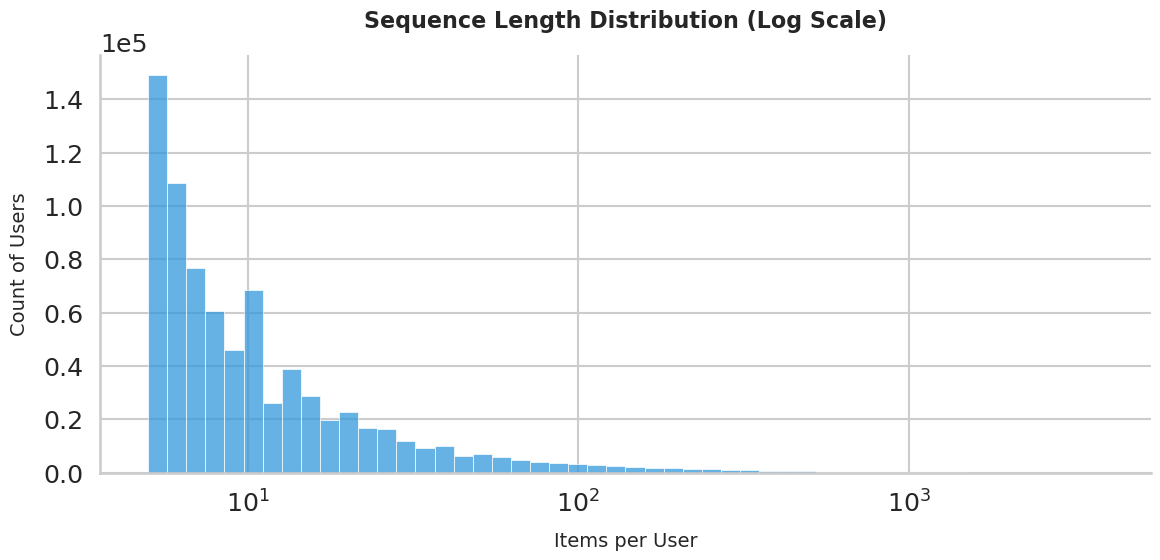

In [6]:
def plot_seq_lengths(lengths):
    if not lengths: return
    plt.figure(figsize=(12, 6))
    
    # Log scale is critical here
    sns.histplot(lengths, bins=50, log_scale=True, 
                 color='#3498db', edgecolor='white', linewidth=0.5)
    
    plt.title("Sequence Length Distribution (Log Scale)", pad=20)
    plt.xlabel("Items per User", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    # Sci notation for Y axis
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    sns.despine()
    plt.tight_layout()
    plt.show()
    
plot_seq_lengths(seq_results['lengths'])

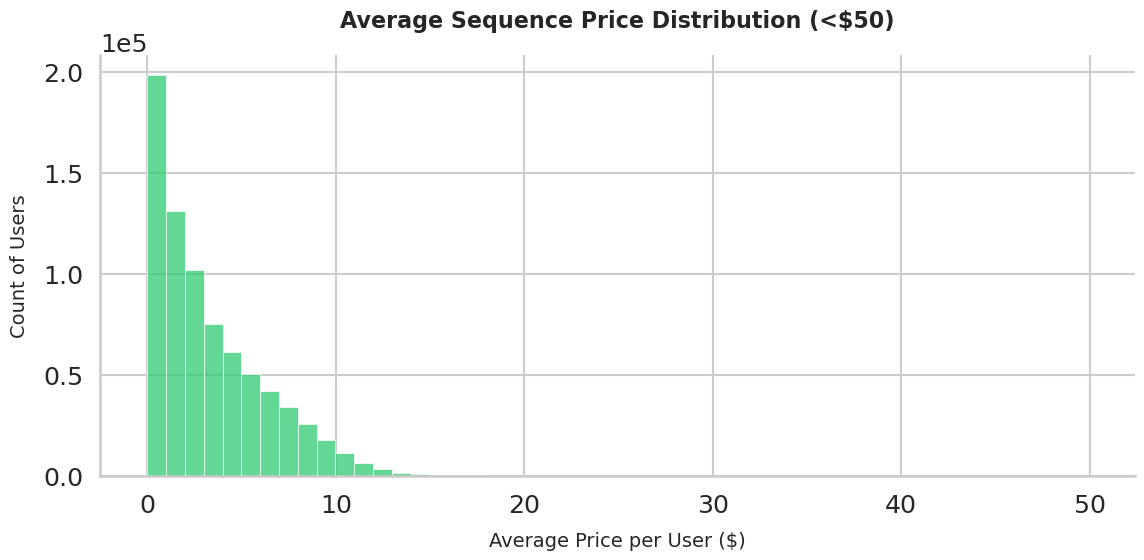

In [7]:
def plot_seq_prices(avg_prices):
    if not avg_prices: return
    # Cap at $50 for visibility
    vis_prices = [p for p in avg_prices if p <= 50]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(vis_prices, bins=50, 
                 color='#2ecc71', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Sequence Price Distribution (<$50)", pad=20)
    plt.xlabel("Average Price per User ($)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_prices(seq_results['avg_prices'])

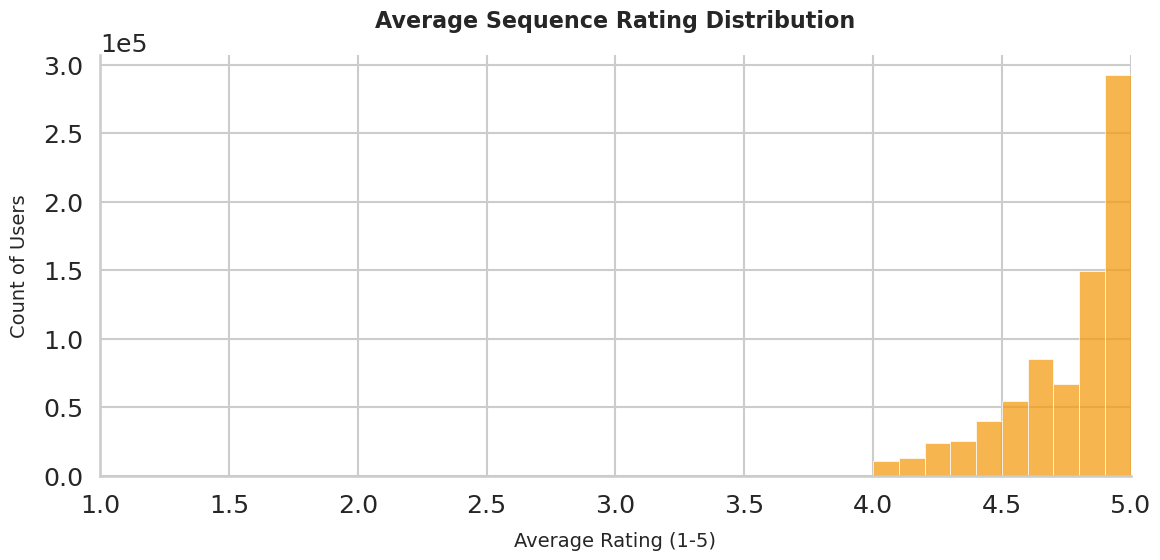

In [8]:
def plot_seq_ratings(avg_ratings):
    if not avg_ratings: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(avg_ratings, bins=10, 
                 color='#f39c12', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Sequence Rating Distribution", pad=20)
    plt.xlabel("Average Rating (1-5)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(1, 5)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_ratings(seq_results['avg_ratings'])

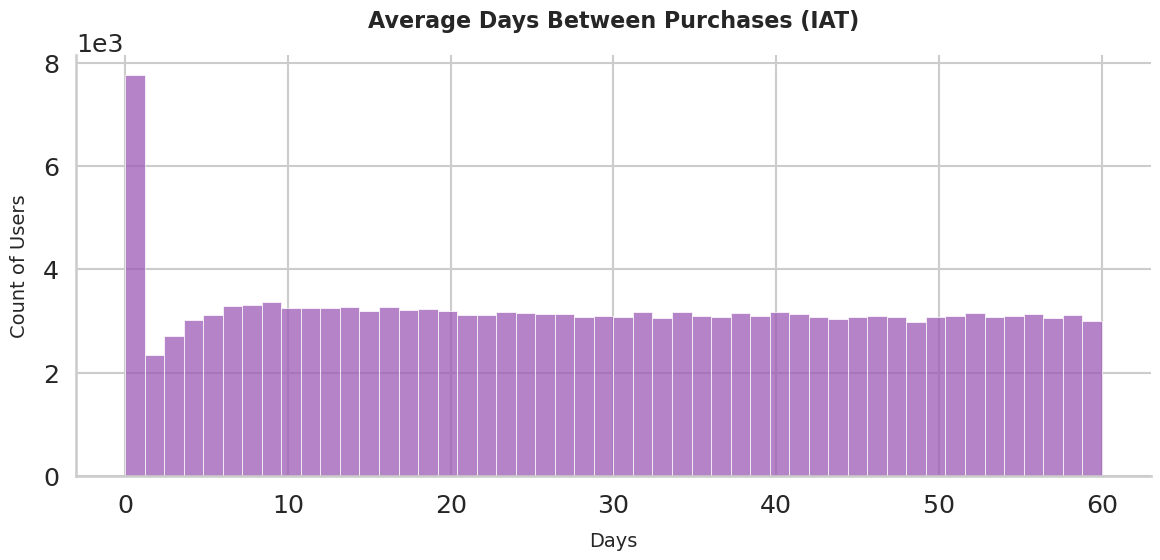

In [9]:
def plot_seq_iat(avg_iat_days):
    if not avg_iat_days: return
    # Cap at 60 days
    vis_iats = [t for t in avg_iat_days if t <= 60]
    
    plt.figure(figsize=(12, 6))
    sns.histplot(vis_iats, bins=50, 
                 color='#9b59b6', edgecolor='white', linewidth=0.5)
    
    plt.title("Average Days Between Purchases (IAT)", pad=20)
    plt.xlabel("Days", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_seq_iat(seq_results['avg_iat_days'])

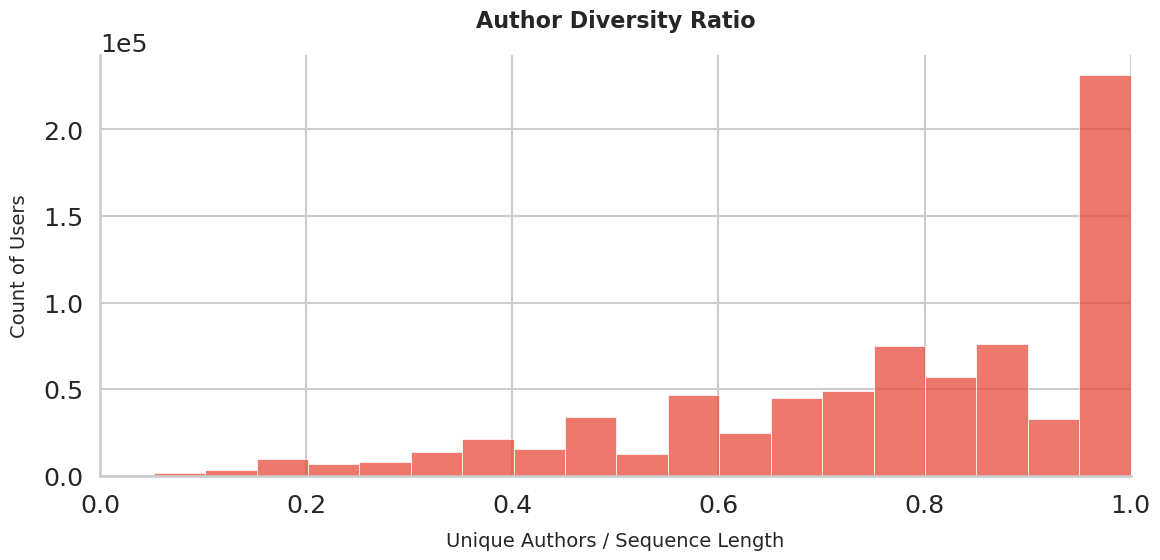

In [10]:
def plot_auth_diversity(author_diversity):
    if not author_diversity: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(author_diversity, bins=20, 
                 color='#e74c3c', edgecolor='white', linewidth=0.5)
    
    plt.title("Author Diversity Ratio", pad=20)
    plt.xlabel("Unique Authors / Sequence Length", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(0, 1)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_auth_diversity(seq_results['author_diversity'])

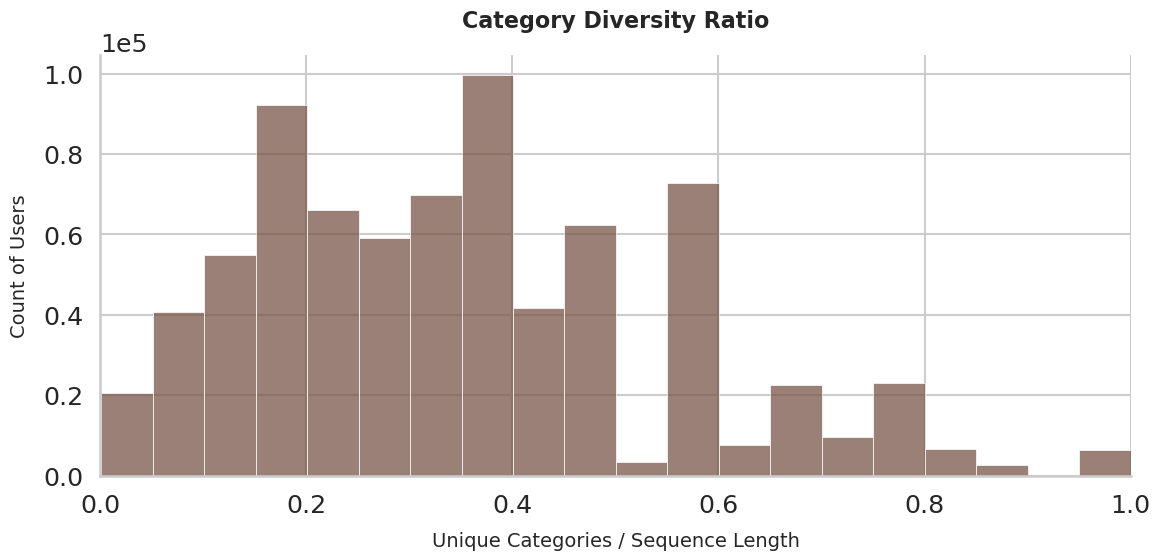

In [11]:
def plot_cat_diversity(cat_diversity):
    if not cat_diversity: return
    plt.figure(figsize=(12, 6))
    
    sns.histplot(cat_diversity, bins=20, 
                 color='#795548', edgecolor='white', linewidth=0.5)
    
    plt.title("Category Diversity Ratio", pad=20)
    plt.xlabel("Unique Categories / Sequence Length", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    plt.xlim(0, 1)
    
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_cat_diversity(seq_results['cat_diversity'])

In [12]:
import gzip
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# 1. Standard text-based tqdm
from tqdm import tqdm 

# --- Global Presentation Settings ---
def set_presentation_style():
    sns.set_context("talk", font_scale=1.1)
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 14

set_presentation_style()

# --- Processing Function ---
def process_advanced_sequences(seq_file, meta_file, top_k=15):
    print("Step 1: Indexing Metadata & Finding Top Genres...")
    
    meta_lookup = {}
    category_counter = Counter()
    
    # Pass 1: Load Metadata to find Top K Genres
    try:
        with gzip.open(meta_file, 'rb') as f:
            for line in tqdm(f, desc="Loading Metadata", unit=" items"):
                try:
                    data = json.loads(line.decode('utf-8').strip())
                    asin = data.get('parent_asin')
                    if not asin: continue
                    
                    # Author
                    author = "UNK"
                    a_obj = data.get('author')
                    if isinstance(a_obj, dict): author = a_obj.get('name', 'UNK')
                    elif isinstance(a_obj, str): author = a_obj
                    
                    # Category
                    cat = "Other"
                    cats = data.get('categories', [])
                    if isinstance(cats, list) and len(cats) > 0:
                        if len(cats) >= 3: cat = cats[2]
                        else: cat = cats[-1]
                    
                    meta_lookup[asin] = {'a': author, 'c': cat}
                    category_counter[cat] += 1
                except: continue
    except FileNotFoundError:
        print(f"Error: {meta_file} not found.")
        return None

    # Identify Top K Genres
    most_common = category_counter.most_common(top_k)
    top_genres = [x[0] for x in most_common]
    valid_genres_set = set(top_genres)
    
    print(f"Top {top_k} Genres identified: {top_genres[:5]}...")

    # --- Step 2: Calculate Metrics ---
    print("\nStep 2: Calculating Advanced Sequence Metrics...")
    
    repetition_scores = [] 
    drift_scores = []      
    
    # Init Transition Matrix
    matrix_keys = top_genres + ["Other"]
    # Dictionary of dictionaries to count transitions
    trans_counts = {k: {k2: 0 for k2 in matrix_keys} for k in matrix_keys}
    
    users_processed = 0
    
    try:
        with gzip.open(seq_file, 'rb') as f:
            for line in tqdm(f, desc="Processing Sequences", unit=" seqs"):
                try:
                    user_obj = json.loads(line.decode('utf-8').strip())
                    seq = user_obj.get('sequence', [])
                    if len(seq) < 2: continue 
                    
                    users_processed += 1
                    
                    # Map Attributes
                    seq_authors = []
                    seq_cats = []
                    
                    for item in seq:
                        meta = meta_lookup.get(item['asin'])
                        if meta:
                            seq_authors.append(meta['a'])
                            c_raw = meta['c']
                            c_mapped = c_raw if c_raw in valid_genres_set else "Other"
                            seq_cats.append(c_mapped)
                        else:
                            seq_authors.append("UNK")
                            seq_cats.append("Other")

                    # A. Author Repetition
                    repeats = 0
                    possible_repeats = len(seq_authors) - 1
                    for i in range(1, len(seq_authors)):
                        if seq_authors[i] == seq_authors[i-1] and seq_authors[i] != "UNK":
                            repeats += 1
                    repetition_scores.append(repeats / possible_repeats)

                    # B. Preference Drift
                    midpoint = len(seq_cats) // 2
                    first_half = set(seq_cats[:midpoint])
                    second_half = set(seq_cats[midpoint:])
                    
                    if not first_half or not second_half:
                        drift_scores.append(0.0)
                    else:
                        intersection = len(first_half.intersection(second_half))
                        union = len(first_half.union(second_half))
                        drift_scores.append(intersection / union)

                    # C. Transition Counts
                    for i in range(len(seq_cats) - 1):
                        src = seq_cats[i]
                        tgt = seq_cats[i+1]
                        trans_counts[src][tgt] += 1
                        
                except: continue
    except FileNotFoundError:
        print(f"Error: {seq_file} not found.")
        return None

    print(f"Done. Analyzed {users_processed:,} sequences.")
    
    # Convert Transition Dict to DataFrame and Normalize
    df_trans = pd.DataFrame(trans_counts).T
    df_norm = df_trans.div(df_trans.sum(axis=1), axis=0).fillna(0)

    return {
        "repetition_scores": repetition_scores,
        "drift_scores": drift_scores,
        "transition_matrix": df_norm # Normalized DataFrame
    }

# --- Execution ---
# Replace with your actual path variables
adv_results = process_advanced_sequences(DATA_PATH + FILE_SEQEUNCES, DATA_PATH + FILE_METADATA)

Step 1: Indexing Metadata & Finding Top Genres...


Loading Metadata: 1591371 items [01:17, 20539.23 items/s]


Top 15 Genres identified: ['Literature & Fiction', 'Romance', 'Religion & Spirituality', 'Science Fiction & Fantasy', "Children's eBooks"]...

Step 2: Calculating Advanced Sequence Metrics...


Processing Sequences: 761756 seqs [00:36, 20913.56 seqs/s]

Done. Analyzed 761,756 sequences.


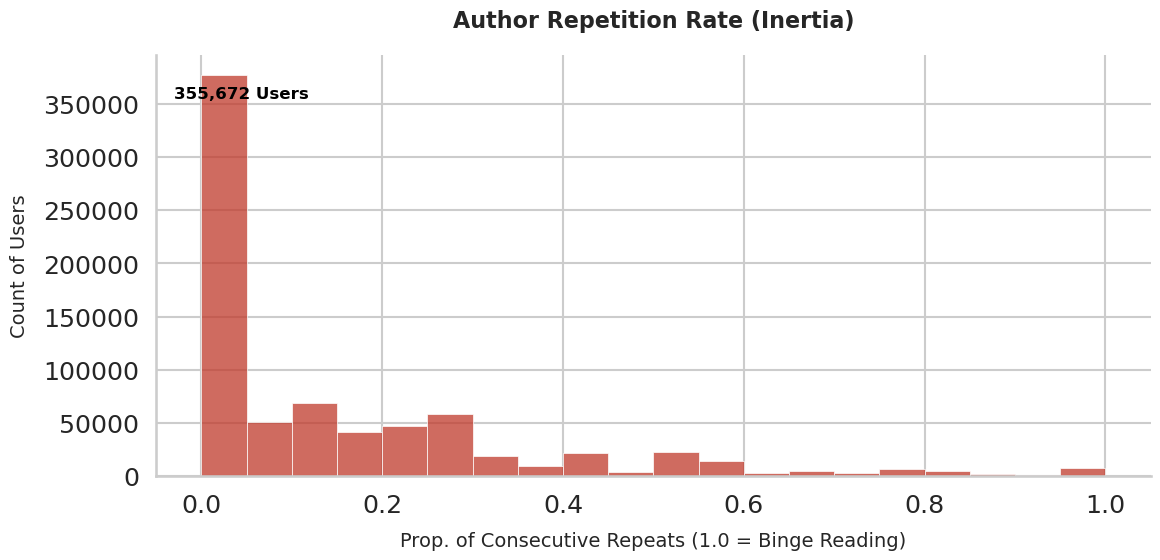

In [13]:
def plot_repetition_beautiful(repetition_scores):
    if not repetition_scores: return
    
    plt.figure(figsize=(12, 6))
    
    # Crimson/Red palette for "Alert/Inertia"
    sns.histplot(repetition_scores, bins=20, 
                 color='#c0392b', edgecolor='white', linewidth=0.5)
    
    plt.title("Author Repetition Rate (Inertia)", pad=20)
    plt.xlabel("Prop. of Consecutive Repeats (1.0 = Binge Reading)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    # Add annotation for the zero bar
    zero_count = sum(1 for x in repetition_scores if x == 0)
    plt.text(-0.03, zero_count, f"{zero_count:,} Users", 
             fontsize=12, color='#000000', fontweight='bold')
    
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_repetition_beautiful(adv_results['repetition_scores'])

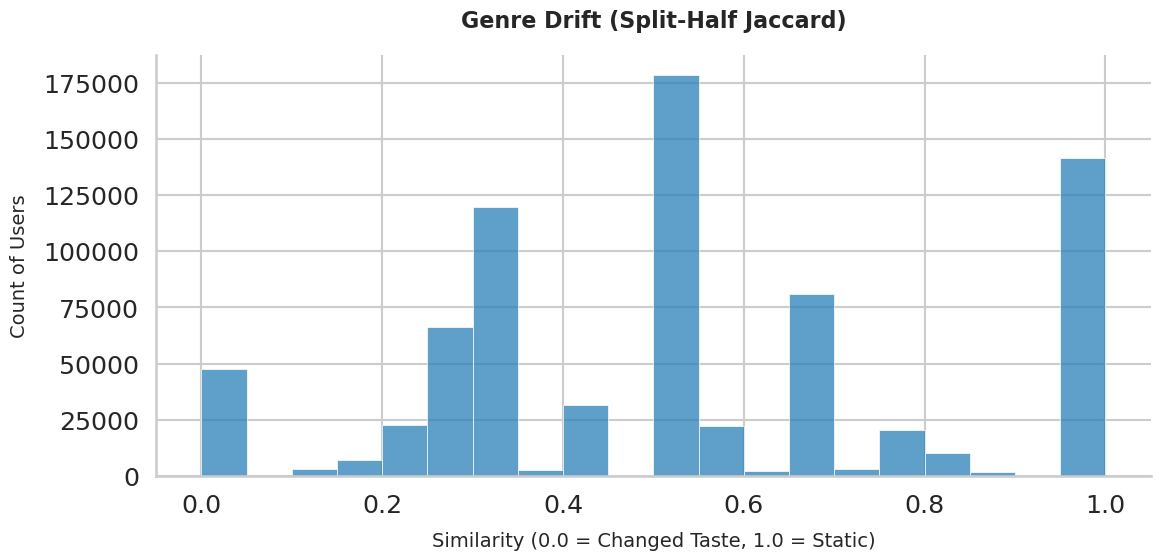

In [14]:
def plot_drift_beautiful(drift_scores):
    if not drift_scores: return
    
    plt.figure(figsize=(12, 6))
    
    # Royal Blue for "Stability"
    sns.histplot(drift_scores, bins=20, 
                 color='#2980b9', edgecolor='white', linewidth=0.5)
    
    plt.title("Genre Drift (Split-Half Jaccard)", pad=20)
    plt.xlabel("Similarity (0.0 = Changed Taste, 1.0 = Static)", labelpad=10)
    plt.ylabel("Count of Users", labelpad=10)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_drift_beautiful(adv_results['drift_scores'])

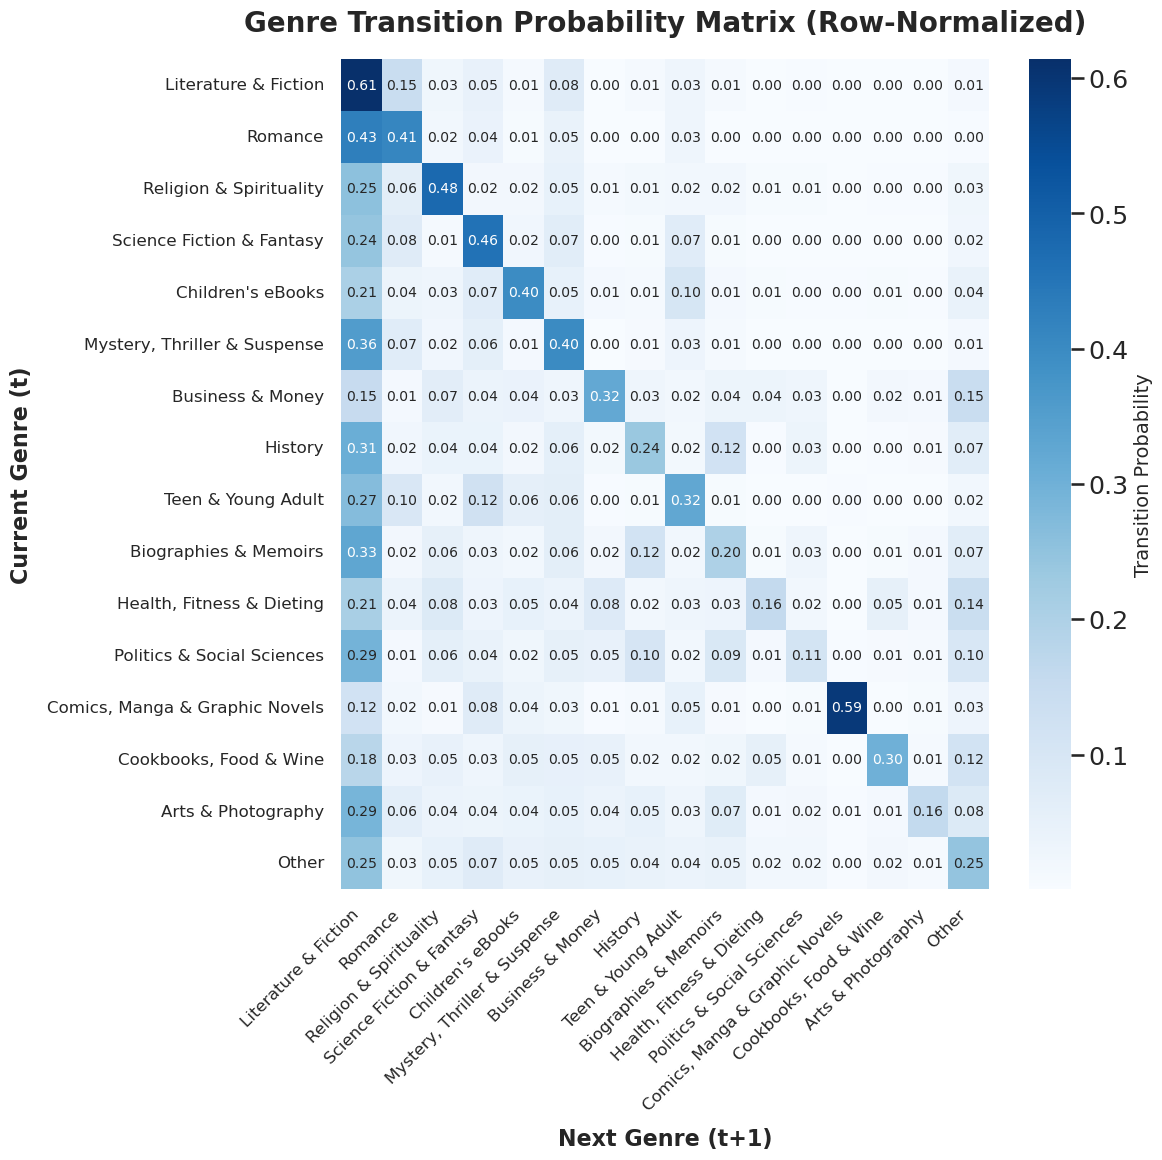

In [19]:
def plot_heatmap_beautiful(transition_matrix):
    if transition_matrix is None or transition_matrix.empty: return
    
    # Increase figure size slightly to accommodate text
    plt.figure(figsize=(12, 12))
    
    # --- 1. Control Annotation Font Size (Numbers inside cells) ---
    # annot_kws={'size': 11} sets the inner font size
    ax = sns.heatmap(transition_matrix, annot=True, fmt=".2f", 
                     cmap="Blues", cbar_kws={'label': 'Transition Probability'},
                     annot_kws={'size': 10}) # <--- CHANGE HERE
    
    # --- 2. Control Title and Axis Label Sizes ---
    ax.set_title("Genre Transition Probability Matrix (Row-Normalized)", 
                 pad=20, fontsize=20, fontweight='bold') # <--- CHANGE HERE
    
    ax.set_xlabel("Next Genre (t+1)", labelpad=10, fontsize=16, fontweight='bold') # <--- CHANGE HERE
    ax.set_ylabel("Current Genre (t)", labelpad=10, fontsize=16, fontweight='bold') # <--- CHANGE HERE
    
    # --- 3. Control Tick Label Sizes (Genre Names) ---
    # rotation=45 helps long genre names fit better
    plt.xticks(rotation=45, ha='right', fontsize=12) # <--- CHANGE HERE
    plt.yticks(rotation=0, fontsize=12)              # <--- CHANGE HERE
    
    # Adjust layout to make sure rotated labels don't get cut off
    plt.tight_layout()
    plt.show()

plot_heatmap_beautiful(adv_results['transition_matrix'])